In [756]:
import numpy as np
import matplotlib.pyplot as plt

In [757]:
from qiskit import QuantumCircuit, transpile, quantum_info
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import (NoiseModel, pauli_error, depolarizing_error)
from qiskit.circuit import Qubit
from qiskit.circuit.library import HGate, XGate, YGate, ZGate, SGate

In [758]:
# (i) Build a simple noise model with depolarizing noise
def construct_noise_model(qubits, noise_prob):
    noise_model = NoiseModel()
    error = pauli_error([('X', noise_prob), ('I', 1 - noise_prob)])
    error = depolarizing_error(noise_prob, 1)
    noise_model.add_quantum_error(error, ['x'], qubits)
    noisy_sim = AerSimulator(noise_model=noise_model)

    return noise_model, noisy_sim

# def bit_flip(p):
    
#     return None

# def phase_flip(p):
    
#     return None

# def depolarizing_channel(p):
#     qcirc = QuantumCircuit(3)

#     qcirc.h(1)
    
#     # qcirc.unitary([[1-p, p], [p, (1-p)]], 2)
#     qcirc.initialize([np.sqrt(1-p), np.sqrt(p)], 2)

#     qcirc.append(SwapGate().control(1), [2, 0, 1])

#     return qcirc

# qcirc_dc = depolarizing_channel(1)
# qcirc_dc.draw("mpl")

In [759]:
# (ii) Create different circuits to test your noise models and choose the observable to measure
gate_population = [
    [HGate, XGate, YGate, ZGate, SGate],
]

def randomized_benchmarking_circuit(n_gates):
    qcirc = QuantumCircuit(1)

    gate_sample_1q = np.random.choice(gate_population[0], n_gates)
    
    shuffled_gates = np.random.permutation(gate_sample_1q)

    for gate in shuffled_gates:
        qcirc.append(gate(), [0])
    
    qcirc = qcirc.compose(qcirc.inverse())
    
    return qcirc

# @TODO - implement more test circuits

In [760]:
# (iii) Apply the unitary folding method
def benchmark_noise(circuit, method, base_noise_level, max_depth_scaling, n_qubits=1):
    qubits = [0 for i in range(n_qubits)]

    scale_factor_step_size = 1 if method == "circuit" else 2

    # noise model
    noise_prob = base_noise_level
    noise_model, noisy_sim = construct_noise_model(qubits, noise_prob)

    noise_data = {}
    for scale_factor in range(1, max_depth_scaling, scale_factor_step_size):
        # quantum circuit with the given observable
        noisy_circuit = QuantumCircuit(n_qubits)
        
        if method == "circuit": # full circuit folding
            k = round(circuit.depth() * (scale_factor - 1)/2)
            n = int(np.floor(k/circuit.depth()))
            s = np.mod(k, circuit.depth())
            
            # original circuit
            noisy_circuit = noisy_circuit.compose(circuit)

            noisy_circuit.barrier()

            # integer foldings
            for i in range(n):
                noisy_circuit = noisy_circuit.compose(circuit, qubits)
                noisy_circuit = noisy_circuit.compose(circuit.inverse(), qubits)
                noisy_circuit.barrier()

            # partial foldings
            partial_circuit = circuit.copy()
            while partial_circuit.depth() > circuit.depth() - s:
                partial_circuit.data.pop(0)
            
            noisy_circuit = noisy_circuit.compose(partial_circuit.inverse())
            noisy_circuit = noisy_circuit.compose(partial_circuit)

            noisy_circuit.barrier()
        elif method == "gate-left": # fold first s gates
            pass
        elif method == "gate-right": # fold last s gates
            pass
        elif method == "gate-random": # fold s random gates
            pass

        noisy_circuit.measure_all()

        if scale_factor == 3:
            noisy_circuit.draw("mpl", filename="noisy_circuit.png")

        # get counts
        noisy_circuit_transpiled = transpile(noisy_circuit, noisy_sim, optimization_level=0)
        result = noisy_sim.run(noisy_circuit_transpiled).result()
        counts = result.get_counts(noisy_circuit_transpiled)

        noise_data[scale_factor] = counts

    return noise_data

In [761]:
def calculate_expectation_values(noise_data):
    expectation_values = {}

    for scale_factor, counts in noise_data.items():
        expectation_value = counts["1"]/(counts["0"]+counts["1"])
        expectation_values[scale_factor] = expectation_value
    
    return expectation_values

In [762]:
# (iv) Apply the extrapolation method to get the zero-noise limit. Different extrapolation methods achieve different results, such as Linear, polynomial, and exponential.
def zero_noise_extrapolation(circuit, method, method_options={}):
    scale_factors = []
    expectation_values = []

    for i in range(10):
        noise_data = benchmark_noise(circuit, "circuit", 0.05, int(1/0.05)-1)
        sample_expectation_values = calculate_expectation_values(noise_data)
        
        scale_factors.append(list(sample_expectation_values.keys()))
        expectation_values.append(list(sample_expectation_values.values()))

    fig, ax = plt.subplots()
    ax.scatter(scale_factors, expectation_values)
    plt.show()

    match method:
        case "linear":
            pass
        case "polynomial":
            pass
        case "exponential":
            pass

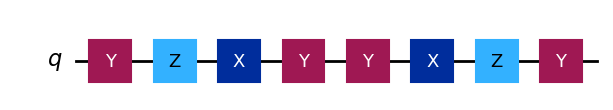

In [763]:
test_circuit = randomized_benchmarking_circuit(4)
test_circuit.draw("mpl")

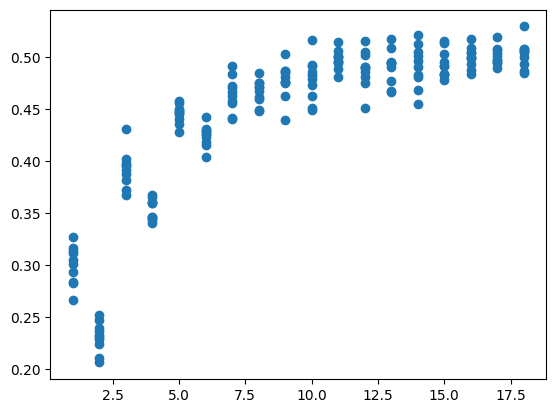

In [764]:
# (v) Compare mitigated and unmitigated results
exp_val_unmitigated = NotImplemented
exp_val_mitigated = zero_noise_extrapolation(test_circuit, "exponential", method_options={})

In [765]:
# (vi) Bonus: Run your ZNE function in real quantum hardware through the IBM Quantum Service
